# Derivatives and Structured Products Coursework
# M.Sc. in International Finance
# Master Level M2 - Academic Year 2025-26
# 

# Group 13 : 
# SHANTNU INGOLE (110524);
# EL GHALI BENAISSA JEMAAOUI (76992); 
# NARENDRA PALLAVAN SIRIYADURAI (110565); 
# BENJAMIN WARD (110577)


# Importing necessary modules

In [22]:
import numpy as np
import pandas as pd
from financepy.utils.global_types import OptionTypes
from financepy.models.black_scholes import bs_value
from financepy.models.black_scholes_analytic import bs_delta
from financepy.utils import Date
from financepy.utils.date import Date
from financepy.products.credit.cds import CDS
from financepy.products.credit.cds_curve import CDSCurve
from financepy.market.curves import DiscountCurveFlat
from financepy.utils import FrequencyTypes
import financepy.utils.math
import scipy.optimize
import matplotlib.pyplot as plt

# Question 1

# Part A&B: DeltaHedge function

In [23]:
def DeltaHedge(S0: float, K: float, T: float, r: float, 
               mu: float, sigma: float, N: int) -> tuple:
    """
    Simulates the delta hedging of a European put option.
    
    Parameters
    ----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk‑free rate
    mu : float
        Stock price drift (expected return)
    sigma : float
        Stock volatility
    N : int
        Number of hedging dates per year
    
    Returns
    -------
    tuple : (S_final, option_payoff, realized_variance, replicating_error)
        - S_final: Terminal stock price
        - option_payoff: Put option payoff
        - realized_variance: Realized variance of returns
        - replicating_error: Replication error (portfolio value − payoff)
    """
    # Fixed parameters
    option_type = OptionTypes.EUROPEAN_PUT
    q = 0.0  # No dividends
    
    # 1. Time grid
    dt = T / N
    times = np.linspace(0, T, N + 1)
    
    # 2. Generation of the stock price path (GBM)
    S = np.zeros(N + 1)
    S[0] = S0
    
    # Generate random shocks
    Z = np.random.standard_normal(N)
    
    # Simulate geometric Brownian motion
    for i in range(1, N + 1):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z[i-1]
        S[i] = S[i-1] * np.exp(drift + diffusion)
    
    # 3. Initialize the portfolio at t = 0
    time_to_expiry = T
    option_price_0 = bs_value(S[0], time_to_expiry, K, r, q, 
                              sigma, option_type.value)
    delta_0 = bs_delta(S[0], time_to_expiry, K, r, q, 
                       sigma, option_type.value)
    
    # Initial portfolio (self‑financing)
    # Sell the option and build the replication portfolio
    shares = delta_0        # Number of shares held
    cash = option_price_0 - shares * S[0]  # Cash after buying the shares
    
    # 4. Dynamic hedging (from t = 1 to t = N − 1)
    for i in range(1, N):
        # Update cash with interest accrued over dt
        cash *= np.exp(r * dt)
        
        # Compute the new delta at date i
        time_left = T - times[i]
        delta_new = bs_delta(S[i], time_left, K, r, q, 
                             sigma, option_type.value)
        
        # Adjust the stock position (self‑financing)
        shares_to_trade = delta_new - shares
        cash -= shares_to_trade * S[i]  # Cost of the adjustment
        shares = delta_new
    
    # 5. Final settlement at maturity (t = N)
    # Update cash with last interest accrual
    cash *= np.exp(r * dt)
    
    # Final position required at maturity
    S_final = S[N]
    if S_final < K:      # Put in the money
        shares_final = -1.0  # Must deliver 1 share
    else:                # Put out of the money
        shares_final = 0.0   # No delivery
    
    # Final adjustment of the position
    cash -= (shares_final - shares) * S_final
    shares = shares_final
    
    # Final portfolio value
    # NOTE: Cash has already accumulated all interest; no extra exp(r*T)
    portfolio_final = shares * S_final + cash
    
    # 6. Quantities to return
    option_payoff = max(K - S_final, 0.0)
    
    # Realized (annualized) variance
    log_returns = np.diff(np.log(S))
    realized_variance = np.sum(log_returns**2) / T
    
    # Replication error
    replicating_error = portfolio_final - option_payoff
    
    return S_final, option_payoff, realized_variance, replicating_error


In [24]:
# ============================================================================
# SIMPLE TEST
# ============================================================================

if __name__ == "__main__":
    print("Test of the corrected DeltaHedge function...")
    print("=" * 60)
    
    # Parameters from question 1(d)
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.04
    mu = 0.05
    sigma = 0.20
    
    # Test with different hedge frequencies
    test_cases = [
        (12, "Monthly"),
        (52, "Weekly"),
        (252, "Daily")
    ]
    
    results = []
    
    for N, label in test_cases:
        print(f"\nTest with {label} hedging (N={N}):")
        print("-" * 60)
        S_T, payoff, var, error = DeltaHedge(S0, K, T, r, mu, sigma, N)
        
        print(f"  Final stock price:      {S_T:.2f}")
        print(f"  Option payoff:          {payoff:.4f}")
        print(f"  Realized variance:      {var:.6f}")
        print(f"  Replication error:      {error:.6f}")
        
        results.append({
            "freq": label,
            "N": N,
            "S_T": S_T,
            "payoff": payoff,
            "variance": var,
            "error": error
        })
    
    print("\n" + "=" * 60)
    print("✓ Test passed!")
    print("\nNote: For statistically meaningful results,")
    print("use the run_multiple_simulations() function from question 1(c).")


Test of the corrected DeltaHedge function...

Test with Monthly hedging (N=12):
------------------------------------------------------------
  Final stock price:      71.34
  Option payoff:          28.6620
  Realized variance:      0.036378
  Replication error:      -0.178417

Test with Weekly hedging (N=52):
------------------------------------------------------------
  Final stock price:      93.39
  Option payoff:          6.6122
  Realized variance:      0.038805
  Replication error:      0.156864

Test with Daily hedging (N=252):
------------------------------------------------------------
  Final stock price:      118.25
  Option payoff:          0.0000
  Realized variance:      0.037800
  Replication error:      0.163345

✓ Test passed!

Note: For statistically meaningful results,
use the run_multiple_simulations() function from question 1(c).


# Part C: Hedging error over n(10,000) different paths

In [25]:
"""
QUESTION 1(c): 10,000 Simulations
"""

def run_multiple_simulations(num_paths=10000, N=52):
    """
    Runs multiple simulations to compute the hedging error.
    """
    # Parameters
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.04
    mu = 0.05
    sigma = 0.20
    
    # Initialize result lists
    terminal_prices = []
    hedging_errors = []
    realized_variances = []
    payoffs = []
    
    print(f"Running {num_paths} simulations with N={N}...")
    
    # Simple progress indicator
    for i in range(num_paths):
        # Run one simulation
        S_T, payoff, realized_var, error = DeltaHedge(
            S0, K, T, r, mu, sigma, N
        )
        
        # Store results
        terminal_prices.append(S_T)
        hedging_errors.append(error)
        realized_variances.append(realized_var)
        payoffs.append(payoff)
        
        # Show progress
        if (i + 1) % 1000 == 0:
            print(f"  {i + 1}/{num_paths} simulations completed")
    
    # Compute statistics
    mean_error = np.mean(hedging_errors)
    var_error = np.var(hedging_errors)
    std_error = np.std(hedging_errors)
    mean_abs_error = np.mean(np.abs(hedging_errors))
    
    print("\nStatistical results:")
    print(f"Mean error:              {mean_error:.6f}")
    print(f"Variance of error:       {var_error:.6f}")
    print(f"Standard deviation:      {std_error:.6f}")
    print(f"Mean absolute error:     {mean_abs_error:.6f}")
    
    return {
        "terminal_prices": np.array(terminal_prices),
        "hedging_errors": np.array(hedging_errors),
        "realized_variances": np.array(realized_variances),
        "payoffs": np.array(payoffs),
        "stats": {
            "mean": mean_error,
            "variance": var_error,
            "std": std_error,
            "mean_abs": mean_abs_error
        }
    }

# Run 1000 simulations
if __name__ == "__main__":
    results = run_multiple_simulations(num_paths=10000, N=52)


Running 10000 simulations with N=52...
  1000/10000 simulations completed
  2000/10000 simulations completed
  3000/10000 simulations completed
  4000/10000 simulations completed
  5000/10000 simulations completed
  6000/10000 simulations completed
  7000/10000 simulations completed
  8000/10000 simulations completed
  9000/10000 simulations completed
  10000/10000 simulations completed

Statistical results:
Mean error:              -0.001501
Variance of error:       0.894962
Standard deviation:      0.946024
Mean absolute error:     0.707889


# Part D: scatterplot of the hedging error (yaxis) versus the terminal stock price (x-axis) for N = 12 (monthly), N = 52 (weekly)and N = 252 (daily).


Generating data for Monthly hedging (N=12)...

Generating data for Weekly hedging (N=52)...

Generating data for Daily hedging (N=252)...


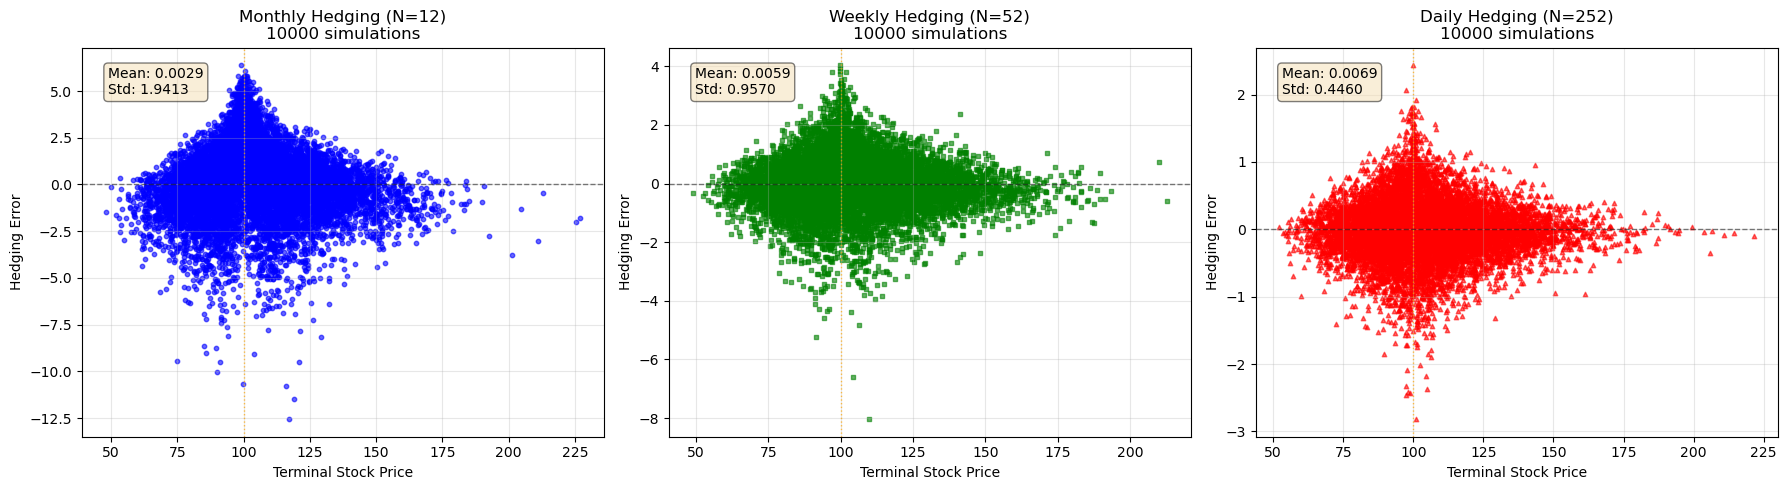

In [26]:
"""
QUESTION 1(d): Scatter Plot
"""
def create_scatter_plots():
    """
    Creates scatter plots for N = 12, 52, 252.
    """
    # Parameters
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.04
    mu = 0.05
    sigma = 0.20
    
    # Number of simulations (reduced for testing; set to 10000 for the report)
    num_paths = 10000
    
    # Configurations to test
    configs = [
        (12, "Monthly", "blue", "o"),
        (52, "Weekly", "green", "s"),
        (252, "Daily", "red", "^")
    ]
    
    # Create the figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (N, label, color, marker) in enumerate(configs):
        print(f"\nGenerating data for {label} hedging (N={N})...")
        
        # Run the simulations
        terminal_prices = []
        hedging_errors = []
        
        for i in range(num_paths):
            S_T, _, _, error = DeltaHedge(S0, K, T, r, mu, sigma, N)
            terminal_prices.append(S_T)
            hedging_errors.append(error)
        
        # Create the scatter plot
        ax = axes[idx]
        ax.scatter(terminal_prices, hedging_errors,
                   alpha=0.6, s=10, c=color, marker=marker)
        
        # Zero line for reference
        ax.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        
        # Line at the strike price
        ax.axvline(x=K, color="orange", linestyle=":", linewidth=1, alpha=0.7)
        
        # Titles and labels
        ax.set_xlabel("Terminal Stock Price")
        ax.set_ylabel("Hedging Error")
        ax.set_title(f"{label} Hedging (N={N})\n{num_paths} simulations")
        ax.grid(True, alpha=0.3)
        
        # Statistics in the plot
        mean_err = np.mean(hedging_errors)
        std_err = np.std(hedging_errors)
        ax.text(0.05, 0.95, f"Mean: {mean_err:.4f}\nStd: {std_err:.4f}",
                transform=ax.transAxes, fontsize=10,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Run
if __name__ == "__main__":
    create_scatter_plots()


# Part E: mean and variance of hedging error for each N

In [27]:
def hedging_error_table():
    Ns = [12, 52, 252]
    num_paths = 10_000

    rows = []
    for N in Ns:
        print(f"Running {num_paths} simulations for N={N} ...")
        results = run_multiple_simulations(num_paths=num_paths, N=N)
        stats = results["stats"]
        rows.append({
            "N": N,
            "Mean hedging error": stats["mean"],
            "Variance of hedging error": stats["variance"]
        })

    table = pd.DataFrame(rows)
    print("\nHedging error summary (10,000 paths):")
    print(table.to_string(index=False))

hedging_error_table()


Running 10000 simulations for N=12 ...
Running 10000 simulations with N=12...
  1000/10000 simulations completed
  2000/10000 simulations completed
  3000/10000 simulations completed
  4000/10000 simulations completed
  5000/10000 simulations completed
  6000/10000 simulations completed
  7000/10000 simulations completed
  8000/10000 simulations completed
  9000/10000 simulations completed
  10000/10000 simulations completed

Statistical results:
Mean error:              -0.016456
Variance of error:       3.759933
Standard deviation:      1.939055
Mean absolute error:     1.460521
Running 10000 simulations for N=52 ...
Running 10000 simulations with N=52...
  1000/10000 simulations completed
  2000/10000 simulations completed
  3000/10000 simulations completed
  4000/10000 simulations completed
  5000/10000 simulations completed
  6000/10000 simulations completed
  7000/10000 simulations completed
  8000/10000 simulations completed
  9000/10000 simulations completed
  10000/10000 simul

# Part F: scatter plot for realized volatility vs replication error

In [28]:
def scatter_realized_vol_vs_error(N=52, num_paths=10_000):
    # Parameters (same as before)
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.04
    mu = 0.05
    sigma = 0.20

    realized_vars = []
    hedging_errors = []

    print(f"Running {num_paths} simulations for N={N} ...")
    for i in range(num_paths):
        S_T, payoff, realized_var, error = DeltaHedge(S0, K, T, r, mu, sigma, N)
        realized_vars.append(realized_var)
        hedging_errors.append(error)

    realized_vars = np.array(realized_vars)
    hedging_errors = np.array(hedging_errors)

    # Convert realized variance to realized volatility (annualized)
    realized_vol = np.sqrt(realized_vars)

    plt.figure(figsize=(7, 4))
    plt.scatter(realized_vol, hedging_errors, s=10, alpha=0.5)
    plt.axhline(0.0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Realized volatility (annualized)")
    plt.ylabel("Replication error")
    plt.title(f"Realized volatility vs replication error (N={N}, {num_paths} paths)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Running 10000 simulations for N=52 ...


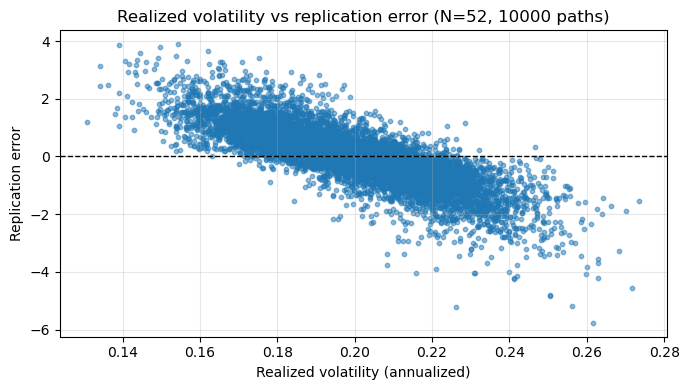

In [29]:
if __name__ == "__main__":
    scatter_realized_vol_vs_error(N=52, num_paths=10000)

# Part G: effect of drift μ on mean absolute error and variance


In [30]:
def drift_sensitivity_table():
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.04
    sigma = 0.20
    N = 52
    num_paths = 10000

    mus = [0.025, 0.05, 0.075, 0.10]
    rows = []

    for mu in mus:
        print(f"\nRunning {num_paths} simulations for mu={mu:.3%}, N={N} ...")
        hedging_errors = []

        for _ in range(num_paths):
            S_T, payoff, realized_var, error = DeltaHedge(S0, K, T, r, mu, sigma, N)
            hedging_errors.append(error)

        hedging_errors = np.array(hedging_errors)
        mean_abs_err = np.mean(np.abs(hedging_errors))
        var_err = np.var(hedging_errors, ddof=1)

        rows.append({
            "mu": f"{mu:.1%}",
            "Mean absolute error": mean_abs_err,
            "Variance of error": var_err
        })

    table = pd.DataFrame(rows)
    print("\nDrift sensitivity of hedging error (N=52, 10,000 paths):")
    print(table.to_string(index=False))

drift_sensitivity_table()


Running 10000 simulations for mu=2.500%, N=52 ...

Running 10000 simulations for mu=5.000%, N=52 ...

Running 10000 simulations for mu=7.500%, N=52 ...

Running 10000 simulations for mu=10.000%, N=52 ...

Drift sensitivity of hedging error (N=52, 10,000 paths):
   mu  Mean absolute error  Variance of error
 2.5%             0.720057           0.926559
 5.0%             0.710246           0.906617
 7.5%             0.702610           0.880481
10.0%             0.689298           0.852547


# -------------------------------------------------------------------------------------------------------------------------------------

# Question 2 : Impact of the moneyness

# Part A:  20% ITM Moneyness for Put

In [31]:
#Step 1: adjust the strike for 20% log forward moneyness
S0 = 100.0
T = 1.0
r = 0.04
q = 0.0

F0 = S0 * np.exp((r - q) * T)
m = -0.2                           # 20% ITM for the put
K_ITM = F0 / np.exp(m)             # = F0 * exp(0.2)
print("New strike (20% ITM put):", K_ITM)

New strike (20% ITM put): 127.12491503214048



Running 10000 simulations for N=12 (20% ITM put)...

Running 10000 simulations for N=52 (20% ITM put)...

Running 10000 simulations for N=252 (20% ITM put)...


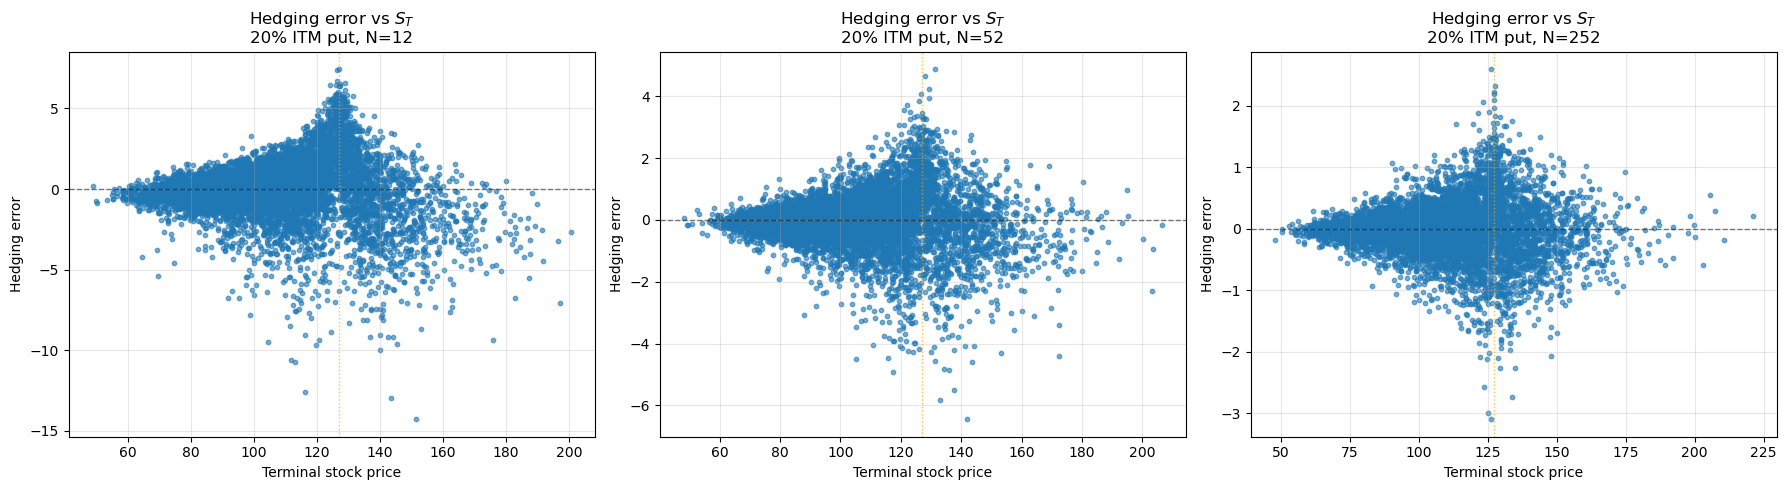


Descriptive statistics for 20% ITM put (10000paths):
  N  Mean error  Variance  Std dev  Mean abs error
 12    0.001618  2.926442 1.710685        1.121730
 52   -0.001481  0.685249 0.827797        0.539571
252   -0.003733  0.152875 0.390993        0.253331


In [32]:
#Step 2: reuse the previous simulation for monthly/weekly/daily with 20% ITM
#Step 3: scatterplot hedging error vs terminal stock price

def stats_and_scatter_moneyness(num_paths=10_000):
    # Base parameters
    S0 = 100.0
    T = 1.0
    r = 0.04
    q = 0.0
    mu = 0.05
    sigma = 0.20

    # 20% ITM put in log forward moneyness: m = log(F0/K) = -0.2
    F0 = S0 * np.exp((r - q) * T)
    m = -0.2
    K = F0 / np.exp(m)          # = F0 * exp(0.2)

    Ns = [12, 52, 252]
    rows = []

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, N in enumerate(Ns):
        print(f"\nRunning {num_paths} simulations for N={N} (20% ITM put)...")

        terminal_prices = []
        hedging_errors = []

        for _ in range(num_paths):
            S_T, _, _, err = DeltaHedge(S0, K, T, r, mu, sigma, N)
            terminal_prices.append(S_T)
            hedging_errors.append(err)

        terminal_prices = np.array(terminal_prices)
        hedging_errors = np.array(hedging_errors)

        # ----- descriptive statistics -----
        mean_err = np.mean(hedging_errors)
        var_err = np.var(hedging_errors, ddof=1)
        std_err = np.std(hedging_errors, ddof=1)
        mean_abs_err = np.mean(np.abs(hedging_errors))

        rows.append({
            "N": N,
            "Mean error": mean_err,
            "Variance": var_err,
            "Std dev": std_err,
            "Mean abs error": mean_abs_err
        })

        # ----- scatterplot -----
        ax = axes[idx]
        ax.scatter(terminal_prices, hedging_errors,
                   alpha=0.6, s=10, c="tab:blue")
        ax.axhline(0.0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax.axvline(K, color="orange", linestyle=":", linewidth=1, alpha=0.7)
        ax.set_xlabel("Terminal stock price")
        ax.set_ylabel("Hedging error")
        ax.set_title(f"Hedging error vs $S_T$\n20% ITM put, N={N}")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ----- print table of descriptive statistics -----
    table = pd.DataFrame(rows)
    print("\nDescriptive statistics for 20% ITM put (", num_paths, "paths):", sep="")
    print(table.to_string(index=False))

# call the function
if __name__ == "__main__":
    stats_and_scatter_moneyness(num_paths=10000)


# Part B: 20% OTM Moneyness


Running 10000 simulations for N=12 (20% OTM put)...

Running 10000 simulations for N=52 (20% OTM put)...

Running 10000 simulations for N=252 (20% OTM put)...


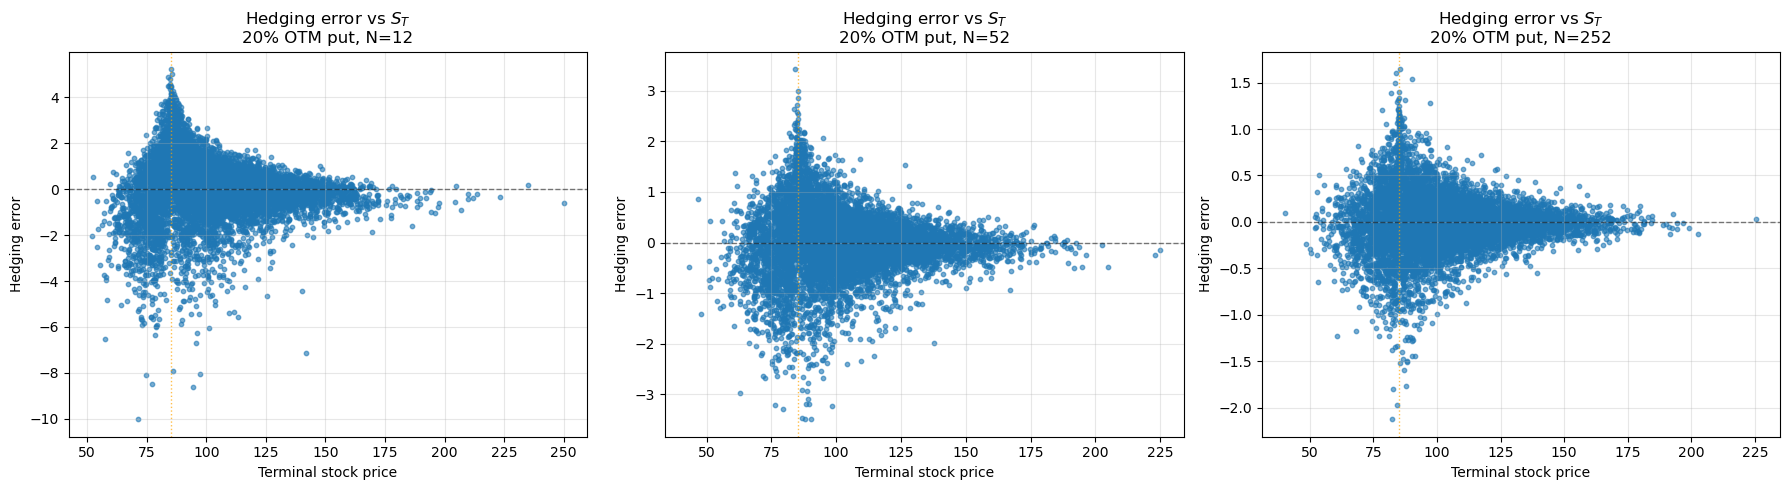


Descriptive statistics for 20% OTM put (10000 paths):
  N  Mean error  Variance  Std dev  Mean abs error
 12    0.001699  1.545518 1.243189        0.850629
 52    0.002871  0.366170 0.605120        0.416007
252   -0.003190  0.080179 0.283159        0.191680


In [33]:
def stats_and_scatter_moneyness_otm(num_paths=10_000):
    # Base parameters
    S0 = 100.0
    T = 1.0
    r = 0.04
    q = 0.0
    mu = 0.05
    sigma = 0.20

    # 20% OTM put: m = log(F0 / K) = +0.2
    F0 = S0 * np.exp((r - q) * T)
    m = 0.2
    K = F0 / np.exp(m)          # = F0 * exp(-0.2)

    Ns = [12, 52, 252]
    rows = []

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, N in enumerate(Ns):
        print(f"\nRunning {num_paths} simulations for N={N} (20% OTM put)...")

        terminal_prices = []
        hedging_errors = []

        for _ in range(num_paths):
            S_T, _, _, err = DeltaHedge(S0, K, T, r, mu, sigma, N)
            terminal_prices.append(S_T)
            hedging_errors.append(err)

        terminal_prices = np.array(terminal_prices)
        hedging_errors = np.array(hedging_errors)

        # ----- descriptive statistics -----
        mean_err = np.mean(hedging_errors)
        var_err = np.var(hedging_errors, ddof=1)
        std_err = np.std(hedging_errors, ddof=1)
        mean_abs_err = np.mean(np.abs(hedging_errors))

        rows.append({
            "N": N,
            "Mean error": mean_err,
            "Variance": var_err,
            "Std dev": std_err,
            "Mean abs error": mean_abs_err
        })

        # ----- scatterplot -----
        ax = axes[idx]
        ax.scatter(terminal_prices, hedging_errors,
                   alpha=0.6, s=10, c="tab:blue")
        ax.axhline(0.0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax.axvline(K, color="orange", linestyle=":", linewidth=1, alpha=0.7)
        ax.set_xlabel("Terminal stock price")
        ax.set_ylabel("Hedging error")
        ax.set_title(f"Hedging error vs $S_T$\n20% OTM put, N={N}")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ----- print table of descriptive statistics -----
    table = pd.DataFrame(rows)
    print("\nDescriptive statistics for 20% OTM put (", num_paths, " paths):", sep="")
    print(table.to_string(index=False))

# Example call
if __name__ == "__main__":
    stats_and_scatter_moneyness_otm(num_paths=10_000)


# Part C : Comparing ITM, OTM, ATM

In [34]:
#code for ATM

def stats_and_scatter_atm(num_paths=10_000):
    # Base parameters
    S0 = 100.0
    K = 100.0          # ATM put
    T = 1.0
    r = 0.04
    mu = 0.05
    sigma = 0.20

    Ns = [12, 52, 252]
    rows = []

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, N in enumerate(Ns):
        print(f"\nRunning {num_paths} simulations for N={N} (ATM put)...")

        terminal_prices = []
        hedging_errors = []

        for _ in range(num_paths):
            S_T, _, _, err = DeltaHedge(S0, K, T, r, mu, sigma, N)
            terminal_prices.append(S_T)
            hedging_errors.append(err)

        terminal_prices = np.array(terminal_prices)
        hedging_errors = np.array(hedging_errors)

        # ----- descriptive statistics -----
        mean_err = np.mean(hedging_errors)
        var_err = np.var(hedging_errors, ddof=1)
        std_err = np.std(hedging_errors, ddof=1)
        mean_abs_err = np.mean(np.abs(hedging_errors))

        rows.append({
            "N": N,
            "Mean error": mean_err,
            "Variance": var_err,
            "Std dev": std_err,
            "Mean abs error": mean_abs_err
        })

        # ----- scatterplot -----
        ax = axes[idx]
        ax.scatter(terminal_prices, hedging_errors,
                   alpha=0.6, s=10, c="tab:blue")
        ax.axhline(0.0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax.axvline(K, color="orange", linestyle=":", linewidth=1, alpha=0.7)
        ax.set_xlabel("Terminal stock price")
        ax.set_ylabel("Hedging error")
        ax.set_title(f"Hedging error vs $S_T$\nATM put, N={N}")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ----- print table of descriptive statistics -----
    table = pd.DataFrame(rows)
    print("\nDescriptive statistics for ATM put (", num_paths, " paths):", sep="")
    print(table.to_string(index=False))



Running 10000 simulations for N=12 (ATM put)...

Running 10000 simulations for N=52 (ATM put)...

Running 10000 simulations for N=252 (ATM put)...


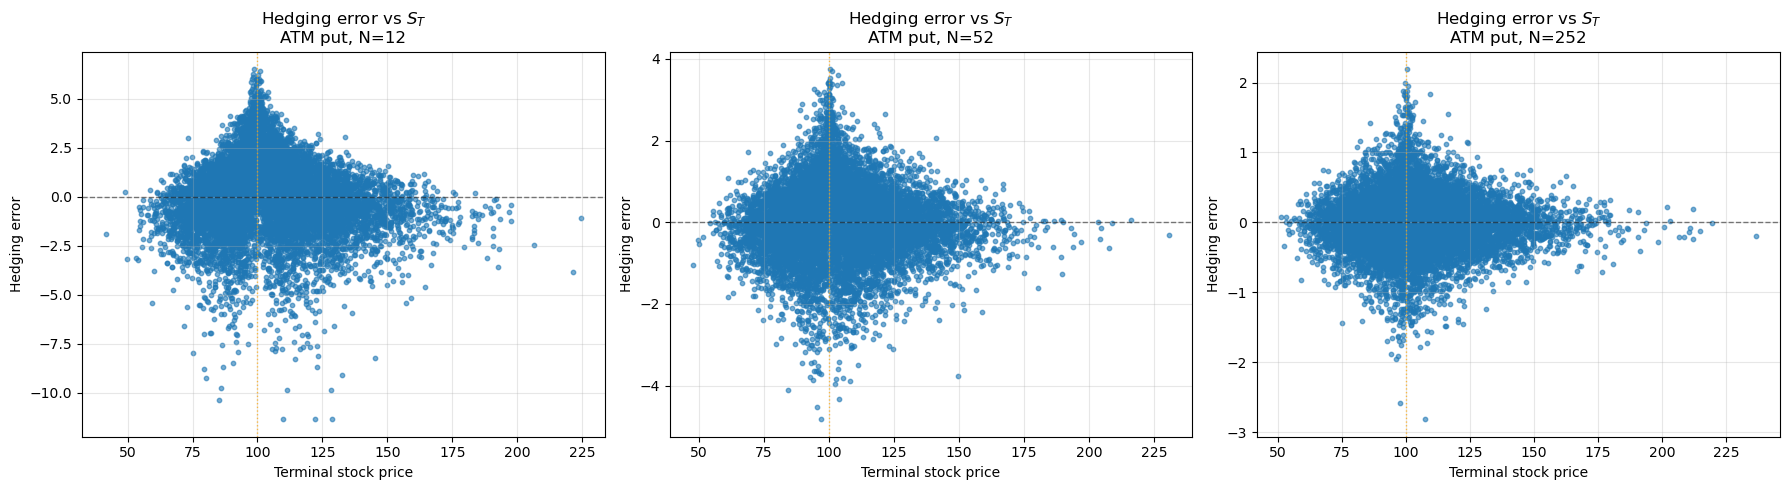


Descriptive statistics for ATM put (10000 paths):
  N  Mean error  Variance  Std dev  Mean abs error
 12   -0.006514  3.744328 1.935027        1.463716
 52    0.000257  0.869008 0.932206        0.702530
252    0.003069  0.186103 0.431397        0.321080


In [35]:
# Example call
if __name__ == "__main__":
    stats_and_scatter_atm(num_paths=10_000)

# -------------------------------------------------------------------------------------------------------------------------------------

# QUESTION 3: INFLATION MARKETS

# Part A: CALIBRATE I(0,T)

In [36]:
print("\n" + "="*80)
print("QUESTION 3: INFLATION MARKETS")
print("="*80)

# ----------------------------
# Input market & table data
# ----------------------------
# Table 1: ZC swap quotes (annual rates)
quoted_maturities = np.array([1,2,3,4,5,6,7,8,9,10,11,12,15,20,25,30], dtype=float)
quoted_rates = np.array([
    6.05, 4.30, 3.50, 3.15, 2.95, 2.90, 2.70, 2.65, 2.60, 2.55,
    2.50, 2.48, 2.46, 2.44, 2.42, 2.40
]) / 100.0

# Table 3: Inflation history (base)
CPI_Aug_25 = 120.70
CPI_Sep_25 = 120.24  # provided but not used in calibration

# Nominal interest rate flat
nominal_rate = 0.03

# Table 4: Real liability profile (in millions) -> convert to same currency units (e.g., millions)
liabilities = pd.DataFrame({
    "Maturity_yrs": [1,2,3,4,5,6,7,8,9,10,11,12,15,20,25,30],
    "Real_Liab_million": [1,2,4,5,8,10,12,15,18,25,23,20,15,9,6,2]  # in millions
})
# convert to currency units (e.g., if you want absolute units, multiply by 1e6)
UNIT_MULT = 1e6
liabilities["Real_Liab"] = liabilities["Real_Liab_million"] * UNIT_MULT

# Table 5: CDS quotes (kept for reference)
cds_quotes_bp = pd.DataFrame({
    "Maturity": [1,2,3,4,5],
    "Quote_bp": [75,78,80,85,90]
})

# ----------------------------
# (a) CALIBRATE I(0,T)
# Interpretation: (1 + s_T)^T = I(0,T)/I(0,0)
# ----------------------------
I_quoted = CPI_Aug_25 * (1.0 + quoted_rates) ** quoted_maturities
inflation_curve_df = pd.DataFrame({
    "T (yrs)": quoted_maturities,
    "ZC rate (%)": quoted_rates * 100,
    "I(0,T) (CPI level)": I_quoted
})
print("\n=== (a) Implied CPI at quoted maturities ===")
print(inflation_curve_df.to_string(index=False))



QUESTION 3: INFLATION MARKETS

=== (a) Implied CPI at quoted maturities ===
 T (yrs)  ZC rate (%)  I(0,T) (CPI level)
     1.0         6.05          128.002350
     2.0         4.30          131.303374
     3.0         3.50          133.822248
     4.0         3.15          136.641997
     5.0         2.95          139.585088
     6.0         2.90          143.284601
     7.0         2.70          145.445529
     8.0         2.65          148.791766
     9.0         2.60          152.066488
    10.0         2.55          155.261550
    11.0         2.50          158.368860
    12.0         2.48          161.948403
    15.0         2.46          173.789104
    20.0         2.44          195.478351
    25.0         2.42          219.445438
    30.0         2.40          245.870242


# Part B: Interpolate (log-linear) and output forward CPI for requested months

In [37]:
# ----------------------------
# (b) Interpolate (log-linear) and output forward CPI for requested months
# Requested: Aug-26..Aug-37 (T=1..12), Aug-40 (T=15), Aug-55 (T=30)
# We'll build I(0,T) for T=1..55 (Aug-26..Aug-2080? but we stop at 55)
# ----------------------------
T_grid = np.arange(1, 56)  # 1..55 years
logI_known = np.log(I_quoted)
logI_interp = np.interp(T_grid, quoted_maturities, logI_known)  # linear in log-space
I_all = np.exp(logI_interp)

forward_df = pd.DataFrame({
    "T (yrs)": T_grid,
    "Calendar Year": (2025 + T_grid).astype(int),
    "I(0,T) (CPI level)": I_all
})

requested_T = list(range(1,13)) + [15, 30]  # T=1..12, 15, 30
requested_forward = forward_df[forward_df["T (yrs)"].isin(requested_T)].copy()
requested_forward["Label"] = ["Aug-" + str(2025 + int(t)) for t in requested_forward["T (yrs)"].values]

print("\n=== (b) Forward CPI for requested dates (log-linear interp) ===")
print(requested_forward[["Label","T (yrs)","I(0,T) (CPI level)"]].to_string(index=False))

# Also create a clean table for Aug-26..Aug-37
print("\nFull list Aug-26..Aug-37 (T=1..12):")
print(forward_df[forward_df["T (yrs)"].between(1,12)][["T (yrs)","Calendar Year","I(0,T) (CPI level)"]].to_string(index=False))


=== (b) Forward CPI for requested dates (log-linear interp) ===
   Label  T (yrs)  I(0,T) (CPI level)
Aug-2026        1          128.002350
Aug-2027        2          131.303374
Aug-2028        3          133.822248
Aug-2029        4          136.641997
Aug-2030        5          139.585088
Aug-2031        6          143.284601
Aug-2032        7          145.445529
Aug-2033        8          148.791766
Aug-2034        9          152.066488
Aug-2035       10          155.261550
Aug-2036       11          158.368860
Aug-2037       12          161.948403
Aug-2040       15          173.789104
Aug-2055       30          245.870242

Full list Aug-26..Aug-37 (T=1..12):
 T (yrs)  Calendar Year  I(0,T) (CPI level)
       1           2026          128.002350
       2           2027          131.303374
       3           2028          133.822248
       4           2029          136.641997
       5           2030          139.585088
       6           2031          143.284601
       7           2

# Part C: PV01 for quoted inflation swaps

In [38]:
# ----------------------------
# (c) PV01 for quoted inflation swaps
# We'll compute PV01 (change in PV per +1 bp) per 1 unit notional (i.e., payoff = I(T)/I0 - 1)
# Fixed leg total payoff per unit = (1+s)^T - 1 ; PV of fixed leg = DF(T) * fixed_pay
# Compute PV01 via finite difference and confirm analytic derivative:
# analytic d/ds [ (1+s)^T -1 ] = T*(1+s)^(T-1)
# PV01 (per +1bp) = DF(T) * T*(1+s)^(T-1) * 0.0001
# ----------------------------
def df(t, r=nominal_rate):
    return 1.0 / ((1 + r) ** t)

pv01_rows = []
for T, s in zip(quoted_maturities, quoted_rates):
    DF = df(T)
    fixed_pay = (1 + s)**T - 1.0
    # finite diff bump
    s_bumped = s + 0.0001
    fixed_pay_bumped = (1 + s_bumped)**T - 1.0
    pv_change_fd = DF * (fixed_pay_bumped - fixed_pay)
    pv01_fd = pv_change_fd / 0.0001  # change per 1bp
    # analytic:
    analytic_derivative = DF * T * (1 + s)**(T - 1)
    pv01_analytic = analytic_derivative  # this is change per unit of s; to get per bp multiply by 0.0001
    pv01_analytic_bp = pv01_analytic * 0.0001

    pv01_rows.append({
        "T (yrs)": T,
        "ZC rate (%)": s*100,
        "DF": DF,
        "Fixed_pay": fixed_pay,
        "PV01_fd (per +1bp, currency units per 1 notional)": pv01_fd,
        "PV01_analytic (per +1bp)": pv01_analytic_bp,
        "FD_vs_Analytic_diff": pv01_fd - pv01_analytic_bp
    })

pv01_df = pd.DataFrame(pv01_rows)
print("\n=== (c) PV01 for quoted ZC inflation swaps (per 1 unit notional) ===")
print(pv01_df.to_string(index=False))


=== (c) PV01 for quoted ZC inflation swaps (per 1 unit notional) ===
 T (yrs)  ZC rate (%)       DF  Fixed_pay  PV01_fd (per +1bp, currency units per 1 notional)  PV01_analytic (per +1bp)  FD_vs_Analytic_diff
     1.0         6.05 0.970874   0.060500                                           0.970874                  0.000097             0.970777
     2.0         4.30 0.942596   0.087849                                           1.966349                  0.000197             1.966153
     3.0         3.50 0.915142   0.108718                                           2.941252                  0.000294             2.940958
     4.0         3.15 0.888487   0.132080                                           3.901054                  0.000390             3.900664
     5.0         2.95 0.862609   0.156463                                           4.845891                  0.000484             4.845407
     6.0         2.90 0.837484   0.187114                                           5.7984

# Part D: Nominal and real values of the Table 4 liabilities

In [47]:
# ----------------------------
# (d) Nominal and real values of the Table 4 liabilities
# Table4: given as real liabilities (in millions). We calculate:
#  - Nominal cashflow at T: Real_amount * I(0,T) / I(0,0)
#  - Nominal PV: discount nominal CF at nominal_rate
#  - Real PV (today's currency, i.e., present value in real terms): discount Real_amount at implied real rate
#
# The implied spot inflation between 0 and T is (I(0,T)/I0)^(1/T) - 1
# The implied real rate r_real_T = (1+nominal_rate)/(1+spot_inflation_T) - 1
# Real PV = Real_amount / (1 + r_real_T)^T
# ----------------------------
vals = []
for _, row in liabilities.iterrows():
    T = int(row["Maturity_yrs"])
    real_amount = row["Real_Liab"]  # in currency units (e.g., euros)
    I_T = float(I_all[T - 1])  # using interpolated I_all (T>=1)
    nominal_cf = real_amount * (I_T / CPI_Aug_25)
    df_nom = df(T)
    pv_nominal = nominal_cf * df_nom

    # implied spot inflation between 0..T
    spot_infl = (I_T / CPI_Aug_25) ** (1.0 / T) - 1.0
    real_rate = (1 + nominal_rate) / (1 + spot_infl) - 1.0
    # avoid numerical issues for 0 or negative T
    if T <= 0:
        pv_real = real_amount
    else:
        pv_real = real_amount / ((1 + real_rate) ** T)

    vals.append({
        "T (yrs)": T,
        "Real_amount": real_amount,
        "I(0,T)": I_T,
        "Nominal_CF": nominal_cf,
        "PV_nominal": pv_nominal,
        "spot_inflation": spot_infl,
        "real_rate": real_rate,
        "PV_real (today EUR)": pv_real
    })

val_df = pd.DataFrame(vals)
# Add a human-readable millions column
val_df["Real_amount_mln"] = val_df["Real_amount"] / UNIT_MULT
val_df["Nominal_CF_mln"] = val_df["Nominal_CF"] / UNIT_MULT
val_df["PV_nominal_mln"] = val_df["PV_nominal"] / UNIT_MULT
val_df["PV_real_mln"] = val_df["PV_real (today EUR)"] / UNIT_MULT

total_nominal_pv = val_df["PV_nominal"].sum()
total_real_pv = val_df["PV_real (today EUR)"].sum()

print("\n=== (d) Liability valuation (Table 4) ===")
print(val_df[[
    "T (yrs)","Real_amount_mln","I(0,T)","Nominal_CF_mln","PV_nominal_mln","spot_inflation","real_rate","PV_real_mln"
]].to_string(index=False))
print(f"\nTotal nominal PV (sum over maturities): {total_nominal_pv:,.2f} (currency units)")
print(f"Total nominal PV (in millions): {total_nominal_pv/UNIT_MULT:,.3f} mln")
print(f"Total real PV (today EUR) (sum): {total_real_pv:,.2f} (currency units)")
print(f"Total real PV (in millions): {total_real_pv/UNIT_MULT:,.3f} mln")


=== (d) Liability valuation (Table 4) ===
 T (yrs)  Real_amount_mln     I(0,T)  Nominal_CF_mln  PV_nominal_mln  spot_inflation  real_rate  PV_real_mln
       1              1.0 128.002350        1.060500        1.029612          0.0605  -0.028760     1.029612
       2              2.0 131.303374        2.175698        2.050804          0.0430  -0.012464     2.050804
       3              4.0 133.822248        4.434872        4.058536          0.0350  -0.004831     4.058536
       4              5.0 136.641997        5.660398        5.029190          0.0315  -0.001454     5.029190
       5              8.0 139.585088        9.251704        7.980601          0.0295   0.000486     7.980601
       6             10.0 143.284601       11.871135        9.941889          0.0290   0.000972     9.941889
       7             12.0 145.445529       14.460202       11.757467          0.0270   0.002921    11.757467
       8             15.0 148.791766       18.491106       14.597050          0.0265 

# Part E: Hedging explanation + quick notional sizing guidance

In [48]:

# ----------------------------
# (e) Hedging explanation + quick notional sizing guidance
# - Interest-rate risk: hedge nominal PV with nominal bonds or receive-fixed IRS sized to match PV/duration.
# - Inflation risk: hedge by RECEIVING inflation (i.e., enter ZC inflation swaps receiving inflation leg)
#   sized to offset the nominal impact of CPI on liabilities (or buy inflation-linked bonds).
#
# Quick notional sizing (very rough):
#  For each T: to hedge inflation exposure of the real liability at T (real_amount):
#   - Nominal exposure at T = real_amount * I(0,T)/I0
#   - A ZC inflation swap that pays (I(T)/I0 - 1) per unit notional: to hedge inflation exposure you would
#     receive inflation on notional N such that N * (I(T)/I0 - 1) ≈ nominal exposure to CPI (or adjust to exact payoff convention).
#
# In practice: match cashflow profiles and durations, consider basis risk and convexity.
# ----------------------------
hedge_text = f"""
=== (e) Hedging guidance ===

1) Interest-rate risk:
   - Nominal PV to hedge (sum): {total_nominal_pv/UNIT_MULT:,.3f} mln
   - Use nominal bonds or receive-fixed interest-rate swaps sized to match the nominal PV and duration.

2) Inflation risk:
   - Liabilities are CPI-indexed (real). To remove inflation exposure, enter zero-coupon inflation swaps where you RECEIVE the inflation leg (i.e., you receive CPI growth).
   - For a specific maturity T, the nominal payment = Real_amount * I(0,T)/I0.
     A ZC inflation swap (per unit notional) pays (I(T)/I0 - 1). Size N such that N*(I(T)/I0 - 1) ≈ nominal payment due to indexation (or use exact replication formulas).
   - Alternatively buy inflation-linked government bonds (linkers) with matching maturities.

3) Combined strategy:
   - Decompose liabilities into nominal & inflation components and hedge each with suitable instruments.
   - Match cashflows and key-rate durations; monitor basis risk between market ZCIS and realized CPI.

"""
print(hedge_text)

# ----------------------------
# (optional) Save results to CSV (uncomment if you run locally and want files)
# inflation_curve_df.to_csv("implied_cpi_quoted.csv", index=False)
# requested_forward.to_csv("forward_requested.csv", index=False)
# pv01_df.to_csv("pv01_zc_infl_swaps.csv", index=False)
# val_df.to_csv("liabilities_valuation.csv", index=False)



=== (e) Hedging guidance ===

1) Interest-rate risk:
   - Nominal PV to hedge (sum): 167.199 mln
   - Use nominal bonds or receive-fixed interest-rate swaps sized to match the nominal PV and duration.

2) Inflation risk:
   - Liabilities are CPI-indexed (real). To remove inflation exposure, enter zero-coupon inflation swaps where you RECEIVE the inflation leg (i.e., you receive CPI growth).
   - For a specific maturity T, the nominal payment = Real_amount * I(0,T)/I0.
     A ZC inflation swap (per unit notional) pays (I(T)/I0 - 1). Size N such that N*(I(T)/I0 - 1) ≈ nominal payment due to indexation (or use exact replication formulas).
   - Alternatively buy inflation-linked government bonds (linkers) with matching maturities.

3) Combined strategy:
   - Decompose liabilities into nominal & inflation components and hedge each with suitable instruments.
   - Match cashflows and key-rate durations; monitor basis risk between market ZCIS and realized CPI.




# -------------------------------------------------------------------------------------------------------------------------------------

# Question 4 : CDS Valuation and Risk

# Part A: Building the CDS Curve

In [41]:
# Part (a): Building the CDS Curve

# Define the trading date (1-Nov-2025)
trade_date = Date(1, 11, 2025)

# CDS maturity dates (1 year from trade date, 2 years etc.)
maturity_dates = [
    Date(1, 11, 2026),  # 1Y
    Date(1, 11, 2027),  # 2Y
    Date(1, 11, 2028),  # 3Y
    Date(1, 11, 2029),  # 4Y
    Date(1, 11, 2030)   # 5Y
]

# CDS quotes in basis points (from the table)
cds_spreads = [75, 78, 80, 85, 90]  # in bp
cds_spreads = np.array(cds_spreads) / 10000  # convert to decimals

# Recovery rate (given as 40%)
recovery_rate = 0.40

# Interest rate curve (flat at 3% as given)
libor_curve_flat_rate_value = 0.03
# Create a DiscountCurveFlat object
libor_curve = DiscountCurveFlat(trade_date, libor_curve_flat_rate_value)

# Create CDS contracts for each maturity
cds_contracts = []
for mat_date, spread in zip(maturity_dates, cds_spreads):
    cds = CDS(trade_date, mat_date, spread, notional=1.0)
    cds_contracts.append(cds)

# Build the CDS curve
cds_curve = CDSCurve(trade_date, cds_contracts, libor_curve, recovery_rate)

print("CDS Curve for Company DoOrDie:")
print(f"- Trade Date: {trade_date}")
print(f"- Recovery Rate: {recovery_rate*100}%")
print(f"- Flat Interest Rate: {libor_curve_flat_rate_value*100}%")
print("\nCDS Contracts in Curve:")
for i, cds in enumerate(cds_contracts):

    print(f"{i+1}Y CDS: Maturity {cds.maturity_dt}, Spread {cds_spreads[i]*10000:.2f}bp")

CDS Curve for Company DoOrDie:
- Trade Date: 01-NOV-2025
- Recovery Rate: 40.0%
- Flat Interest Rate: 3.0%

CDS Contracts in Curve:
1Y CDS: Maturity 01-NOV-2026, Spread 75.00bp
2Y CDS: Maturity 01-NOV-2027, Spread 78.00bp
3Y CDS: Maturity 01-NOV-2028, Spread 80.00bp
4Y CDS: Maturity 01-NOV-2029, Spread 85.00bp
5Y CDS: Maturity 01-NOV-2030, Spread 90.00bp


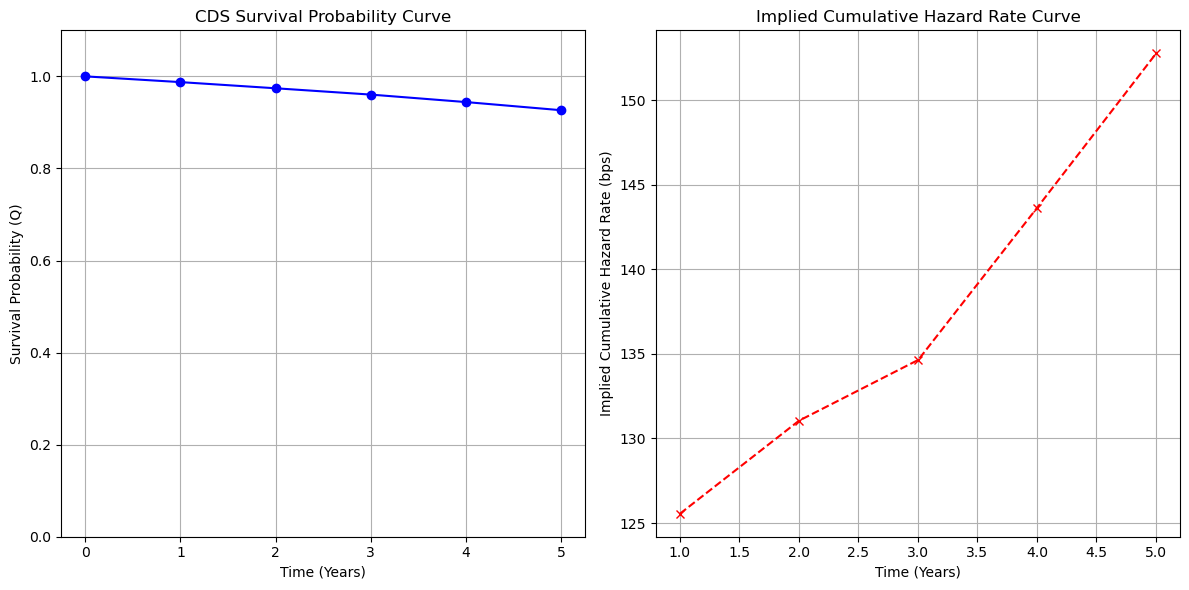

In [42]:
# Extract times and survival probabilities from the CDS curve
times = cds_curve.times
survival_probs = cds_curve.qs


valid_times = times[times > 0]
valid_survival_probs = survival_probs[times > 0]


# h(t) = -ln(S(t)) / t
implied_hazard_rates = -np.log(valid_survival_probs) / valid_times

# Plotting the Survival Probability Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(times, survival_probs, marker='o', linestyle='-', color='blue')
plt.title('CDS Survival Probability Curve')
plt.xlabel('Time (Years)')
plt.ylabel('Survival Probability (Q)')
plt.grid(True)
plt.ylim(0, 1.1)

# Plotting the Implied Cumulative Hazard Rate Curve
plt.subplot(1, 2, 2)
plt.plot(valid_times, implied_hazard_rates * 10000, marker='x', linestyle='--', color='red')
plt.title('Implied Cumulative Hazard Rate Curve')
plt.xlabel('Time (Years)')
plt.ylabel('Implied Cumulative Hazard Rate (bps)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Part B: Market spread of a 4 year CDS Maturing 20-March-2029

In [43]:
# Part (b): market spread of a 4 year CDS Maturing 20-March-2029

# 1. Define the maturity date given in the question
maturity_4y = Date(20, 3, 2029)   # 20-Mar-2029

# 2. Function that returns the PV of the CDS for a given running spread
def cds_pv_for_spread(spread_decimal: float) -> float:
    """
    spread_decimal is the running premium in decimal (e.g. 0.0085 = 85 bp).

    We:
      - construct a CDS with that spread and the given maturity,
      - price it using the discount curve (flat 3%) and the CDSCurve
        calibrated in part (a),
      - return its PV (per unit notional).
    The root of this function (PV = 0) is the par spread.
    """
    try:
        cds_4y = CDS(
            trade_date,      # valuation date (1-Nov-2025)
            maturity_4y,     # contractual maturity 20-Mar-2029
            spread_decimal,  # trial spread
            notional=1.0,
            long_protect=True, # Assuming buying protection, requires a boolean
            freq_type=FrequencyTypes.QUARTERLY # Explicitly set quarterly frequency using enum
        )

        # FinancePy pricing: value of this CDS given:

        pv_dict = cds_4y.value(trade_date, cds_curve, recovery_rate)
        pv = pv_dict['dirty_pv']
        return float(pv)
    except Exception as e:

        return np.nan


# 3. Use a root-finder to get the par spread
#    We give two starting guesses in decimal (50 bp and 150 bp).
spread_guess_1 = 0.005   # 50 bp
s_guess_2 = 0.015   # 150 bp

par_spread_decimal = scipy.optimize.brentq(
    cds_pv_for_spread,
    spread_guess_1,
    s_guess_2
)

# 4. Convert to basis points for reporting
par_spread_bps = par_spread_decimal * 10_000

print(f"Par spread of 4-year CDS (to 20-Mar-2029): {par_spread_bps:.2f} bp")

Par spread of 4-year CDS (to 20-Mar-2029): 79.48 bp


# PART C: Value of an long-protection CDS

In [44]:
"""
PART (c) – Value of an long-protection CDS

Contract details:
- Long protection (protection BUYER)
- Contractual spread: 120 bp = 0.0120 in decimal
- Maturity: 20-Mar-2029 (same as in part b)
- Notional: 20m
- Valuation date and curves are the same as before:
    trade_date = 1-Nov-2025
    discount_curve : flat 3%
    cds_curve      : bootstrapped from part (a)
"""

# 1. Contract parameters
contract_spread_bps = 120.0
contract_spread = contract_spread_bps / 10_000.0   # 0.0120
notional = 20_000_000.0                             # 20m

# 2. Build the CDS that represents THIS contract
cds_existing = CDS(
    trade_date,          # valuation / start date
    maturity_4y,         # maturity 20-Mar-2029 (defined in part b)
    contract_spread,     # contractual running spread = 120 bp
    notional,            # real notional, 20m
    long_protect=True,   # Corrected: explicitly set long_protect to True
    freq_type=FrequencyTypes.QUARTERLY # Corrected: explicitly set frequency type
)

# 3. Value the contract using current market information
#    FinancePy uses:
#        PV = PV(premium leg at 120bp) - PV(protection leg)
#    so sign convention:
#        - If PV < 0 → contract is loss for long protection (buyer),
#        - If PV > 0 → contract is gain for long protection (buyer).

# The .value() method expects valuation_date, issuer_curve, contract_recovery_rate
pv_dict_long_protection = cds_existing.value(trade_date, cds_curve, recovery_rate)
pv_long_protection = pv_dict_long_protection['dirty_pv'] # Extracting the dirty PV

print(f"Value of long-protection CDS (spread = 120 bp, notional = 20m): "
      f"{pv_long_protection:,.2f}")

"""
Economic interpretation:

- From part (b) we computed the *market* (par) spread for a CDS with the same
  maturity. That spread is typically around the quotes in the table (≈ 80–90 bp).
- Here the contractual spread is 120 bp, which is *higher* than the market
  spread. This means:
      • The protection buyer pays 120 bp each year,
      • while new contracts in the market would only pay ≈ par_spread bp.
- Therefore this old contract is economically UNFAVOURABLE for the long
  protection (they overpay) and FAVOURABLE for the protection seller.
- This is reflected in the PV returned above: it should be NEGATIVE for the
  long-protection side and positive for the short-protection side
  (same amount with opposite sign).
"""

Value of long-protection CDS (spread = 120 bp, notional = 20m): -266,185.54


'\nEconomic interpretation:\n\n- From part (b) we computed the *market* (par) spread for a CDS with the same\n  maturity. That spread is typically around the quotes in the table (≈ 80–90 bp).\n- Here the contractual spread is 120 bp, which is *higher* than the market\n  spread. This means:\n      • The protection buyer pays 120 bp each year,\n      • while new contracts in the market would only pay ≈ par_spread bp.\n- Therefore this old contract is economically UNFAVOURABLE for the long\n  protection (they overpay) and FAVOURABLE for the protection seller.\n- This is reflected in the PV returned above: it should be NEGATIVE for the\n  long-protection side and positive for the short-protection side\n  (same amount with opposite sign).\n'

# PART D: Recovery-rate sensitivity of the CDS value

In [45]:
"""
PART (d) – Recovery-rate sensitivity of the CDS value

We now *revalue the same contract as in (c)* (long protection, 120 bp, notional
20m, maturity 20-Mar-2029) for several assumed recovery rates:
R = 0%, 10%, 20%, 30%.

Key idea:
- Market CDS quotes (75–90 bp) are kept fixed.
- For each R we *rebuild* the CDSCurve so that it still fits these quotes.
- Then we price our off-market 120 bp CDS with that curve.
"""

# Define tenors in years and par spreads based on Part (a) data
tenors_in_years = [1, 2, 3, 4, 5]
par_spreads = cds_spreads # Use the cds_spreads defined in part (a)

# 1. Helper: (re)build a CDS curve for a given recovery rate
def build_cds_curve_for_recovery(R: float) -> CDSCurve:
    """
    R: recovery rate in decimal (e.g. 0.40 for 40%).

    For each tenor, we create a par CDS with that recovery rate, then use them
    as pillars to bootstrap a CDSCurve.
    """
    market_cds_R = []
    for tenor, spread in zip(tenors_in_years, par_spreads):
        # Correctly derive maturity date from trade_date and tenor
        maturity_date = trade_date.add_tenor(f"{tenor}Y")
        cds_pillar = CDS(
            trade_date,
            maturity_date,
            spread,     # same quoted market spread as before
            notional=1.0,        # unit notional
            long_protect=True,  # Assuming these are par CDS for bootstrapping
            freq_type=FrequencyTypes.QUARTERLY # quarterly payments
        )
        market_cds_R.append(cds_pillar)

    # Use libor_curve (our discount curve) instead of discount_curve
    curve_R = CDSCurve(trade_date, market_cds_R, libor_curve, R) # Pass R as recovery_rate to CDSCurve
    return curve_R


# 2. Loop over the different recovery rates and compute the contract value
recovery_list = [0.00, 0.10, 0.20, 0.30]
pv_by_recovery = {}

for R in recovery_list:
    # rebuild hazard curve for this R
    cds_curve_R = build_cds_curve_for_recovery(R)

    # build our existing CDS contract with this R
    cds_contract_R = CDS(
        trade_date,
        maturity_4y,
        contract_spread,   # 120 bp from part (c)
        notional,
        long_protect=True,
        freq_type=FrequencyTypes.QUARTERLY               # quarterly
    )

    # price using the curve calibrated with the same R
    # .value() method signature is (value_dt, issuer_curve, contract_recovery_rate)
    pv_dict_R = cds_contract_R.value(trade_date, cds_curve_R, R)
    pv_R = pv_dict_R['dirty_pv']
    pv_by_recovery[R] = pv_R

# 3. Print results in a small table
print("Value of long-protection CDS (spread 120 bp, notional 20m)")
print("Recovery  |   PV (in $)")
print("------------------------------")
for R, pv in pv_by_recovery.items():
    print(f"{int(R*100):>3d}%      | {pv:>12,.2f}")

"""
Interpretation:

- For each R, the CDSCurve is recalibrated so that the quoted 1Y–5Y CDS
  remain par. Rough rule: for fixed market spread s, the hazard rate is
      λ ≈ s / (1 − R)
  so lower R ⇒ higher λ, and higher R ⇒ lower λ.

- When we then price our *off-market* contract (120 bp vs. market ≈ 80–90 bp),
  two effects move in opposite directions:
    • Lower R makes each default more costly (loss given default ↑),
    • but the curve adjusts so that defaults become more (or less) likely.

- Because of this re-calibration, the PV of the contract typically changes
  only moderately when R moves between 0% and 30%: the impact of R on the
  protection leg and on the premium leg largely offsets.

- Conclusion:
    The value is not extremely sensitive to the assumed recovery rate
    once the CDS curve is recalibrated to market spreads. This is why
    dealers focus much more on the *spread* (and its curve) than on small
    changes in the recovery assumption for pricing vanilla CDS.
"""

Value of long-protection CDS (spread 120 bp, notional 20m)
Recovery  |   PV (in $)
------------------------------
  0%      |  -268,300.61
 10%      |  -267,946.39
 20%      |  -267,504.58
 30%      |  -266,938.10


'\nInterpretation:\n\n- For each R, the CDSCurve is recalibrated so that the quoted 1Y–5Y CDS\n  remain par. Rough rule: for fixed market spread s, the hazard rate is\n      λ ≈ s / (1 − R)\n  so lower R ⇒ higher λ, and higher R ⇒ lower λ.\n\n- When we then price our *off-market* contract (120 bp vs. market ≈ 80–90 bp),\n  two effects move in opposite directions:\n    • Lower R makes each default more costly (loss given default ↑),\n    • but the curve adjusts so that defaults become more (or less) likely.\n\n- Because of this re-calibration, the PV of the contract typically changes\n  only moderately when R moves between 0% and 30%: the impact of R on the\n  protection leg and on the premium leg largely offsets.\n\n- Conclusion:\n    The value is not extremely sensitive to the assumed recovery rate\n    once the CDS curve is recalibrated to market spreads. This is why\n    dealers focus much more on the *spread* (and its curve) than on small\n    changes in the recovery assumption for

# PART E: Sensitivity of the CDS value to a +1 bp move in each pillar spread

In [46]:
"""
PART (e) – Sensitivity of the CDS value to a +1 bp move in each pillar spread

We want:
  For each market CDS quote (1Y … 5Y), bump that single spread by +1 bp,
  rebuild the CDS curve, re-price our *existing* 3.5-year CDS
  (20-Mar-2029, 120 bp, notional 20m, long protection)
  and record the change in PV.

This gives the credit-spread DV01 of the trade with respect to each pillar.
"""

# 1. Base PV (no bumps) using the curve calibrated in part (a)
cds_contract_base = CDS(
    trade_date,
    maturity_4y,
    contract_spread,   # 120 bp
    notional,
    long_protect=True, # Corrected: explicitly set long_protect to True
    freq_type=FrequencyTypes.QUARTERLY # Corrected: explicitly set frequency type
)

# Use the .value() method with correct arguments: value_dt, issuer_curve, contract_recovery_rate
pv_dict_base = cds_contract_base.value(trade_date, cds_curve, recovery_rate)
pv_base = pv_dict_base['dirty_pv']


# 2. Loop over pillars, bump one spread at a time by +1 bp
bump_size_bps = 1.0
bump_size = bump_size_bps / 10_000.0   # 0.0001 in decimal

results = []   # will store (tenor, dPV for +1 bp in that tenor)

for j, (tenor, spread) in enumerate(zip(tenors_in_years, par_spreads)):

    # Copy the original spreads and bump only the j-th one
    bumped_spreads = par_spreads.copy()
    bumped_spreads[j] += bump_size

    # Build a new CDS curve with the bumped spreads
    market_cds_bumped_pillars = []
    for t_idx, s_val in enumerate(bumped_spreads):
        mat_date_for_pillar = maturity_dates[t_idx] # Re-use maturity_dates list from part a

        cds_pillar = CDS(
            trade_date,
            mat_date_for_pillar,
            s_val,              # possibly bumped spread
            notional=1.0,        # unit notional for the pillar
            long_protect=True, # Corrected
            freq_type=FrequencyTypes.QUARTERLY # Corrected
        )
        market_cds_bumped_pillars.append(cds_pillar)

    # The recovery_rate for this curve is the global one (40%).
    cds_curve_bumped = CDSCurve(trade_date, market_cds_bumped_pillars, libor_curve, recovery_rate)

    # Re-price our existing 3.5-year contract with this bumped curve
    cds_bumped = CDS(
        trade_date,
        maturity_4y,
        contract_spread,   # contractual 120 bp does NOT change
        notional,
        long_protect=True, # Corrected
        freq_type=FrequencyTypes.QUARTERLY # Corrected
    )

    pv_dict_bumped = cds_bumped.value(trade_date, cds_curve_bumped, recovery_rate)
    pv_bumped = pv_dict_bumped['dirty_pv']

    # Sensitivity of PV to a +1 bp change in this pillar
    dPV = pv_bumped - pv_base

    results.append((tenor, dPV))


# 3. Display the results as a table
print("Change in PV of the 3.5Y CDS (120 bp, 20m notional)")
print("for a +1 bp increase in each market CDS quote")
print("")
print("Tenor  |  dPV per +1 bp  (USD)")
print("--------------------------------")
for tenor, dPV in results:
    print(f"{tenor:>3}Y   |  {dPV:>14,.2f}")

"""
Interpretation:

- Each row is the *credit-spread DV01* of the trade with respect to the
  corresponding pillar (1Y,…,5Y) market CDS spread.
- Typically:
    • The sensitivities are largest to pillars whose maturity is close
      to the maturity of our trade (~3.5Y).
    • Sensitivities to very short or very long maturities are smaller.

- A dealer hedges this 3.5Y CDS mainly by trading liquid standard
  maturities (e.g. 3Y and 5Y single-name CDS or index CDS) such that
  the *net* dPV to key pillars is close to zero:
      • If long protection in the 3.5Y trade (value ↑ when spreads ↑),
        the dealer would *sell* protection in nearby standard maturities
        until the portfolio’s pillar sensitivities offset each other.
- In practice this is done using these DV01 numbers (per pillar) to pick
  hedge notionals, but the question explicitly asks not to compute the
  hedge amounts.
"""

Change in PV of the 3.5Y CDS (120 bp, 20m notional)
for a +1 bp increase in each market CDS quote

Tenor  |  dPV per +1 bp  (USD)
--------------------------------
  1Y   |           11.11
  2Y   |           23.36
  3Y   |        3,509.83
  4Y   |        2,870.44
  5Y   |            0.00


'\nInterpretation:\n\n- Each row is the *credit-spread DV01* of the trade with respect to the\n  corresponding pillar (1Y,…,5Y) market CDS spread.\n- Typically:\n    • The sensitivities are largest to pillars whose maturity is close\n      to the maturity of our trade (~3.5Y).\n    • Sensitivities to very short or very long maturities are smaller.\n\n- A dealer hedges this 3.5Y CDS mainly by trading liquid standard\n  maturities (e.g. 3Y and 5Y single-name CDS or index CDS) such that\n  the *net* dPV to key pillars is close to zero:\n      • If long protection in the 3.5Y trade (value ↑ when spreads ↑),\n        the dealer would *sell* protection in nearby standard maturities\n        until the portfolio’s pillar sensitivities offset each other.\n- In practice this is done using these DV01 numbers (per pillar) to pick\n  hedge notionals, but the question explicitly asks not to compute the\n  hedge amounts.\n'

# --------------------------------------------------------- THE END ----------------------------------------------------------------